# Intro Task, Object Localization

In [39]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [40]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [41]:
import pandas as pd

# File paths
CSV_FILE = '/home/tom/Python/Machine learning/pytorch/object-localisation/object-localization-dataset/train.csv'
DATA_DIR = '/home/tom/Python/Machine learning/pytorch/object-localisation/object-localization-dataset/'

# Device settings
DEVICE = 'cuda'

# Model parameters
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40

# Other constants
NUM_COR = 4
MODEL_NAME = 'efficientnet_b0'


In [42]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [43]:
df.label.unique()

#therefore 3 classes
# so total output dimension in fully connectedlayer layer is 3+1 (1 is for bindingbox)
# note: not sure if output for fullyconnected layer is based on reason mentioned in above line or because the bindingbox has 4 cordinates (xmin, ymin, xmax, ymax)

array(['mushroom', 'eggplant', 'cucumber'], dtype=object)

In [44]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [45]:
import albumentations as A

In [46]:
#This function is to apply transformations to the image aswell as bindingbox in the same way
IMG_SIZE = 224  

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [47]:
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        self.label_map = {"mushroom": 0, "eggplant": 1, "cucumber": 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]
        img_path = DATA_DIR + row.img_path

        label = self.label_map[row.label]
        label = torch.tensor(label, dtype=torch.long)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox, class_labels=[label.item()])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0  # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)
        label = torch.Tensor(label)

        return img, bbox, label

In [48]:
trainset = ObjLocDataset(train_df, augmentations=train_augs)
validset = ObjLocDataset(valid_df, augmentations=valid_augs)

In [49]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


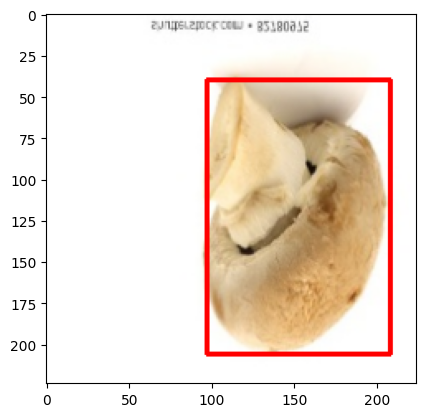

In [50]:
img, bbox, label = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)
print(label)

# Load dataset into batches

In [51]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [53]:
for images,bboxes,label in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))
print("label_shape", print(label.shape))

Shape of one batch images : torch.Size([16, 3, 224, 224])
Shape of one batch bboxes : torch.Size([16, 4])
torch.Size([16])
label_shape None


# Create Model

In [54]:
from torch import nn
import timm

In [55]:
class CustomObjLocModel(nn.Module):
    def __init__(self):
        super(CustomObjLocModel, self).__init__()

        # Replace this with your custom convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Replace this with your custom dense layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.relu3 = nn.ReLU()
        self.fc_bbox = nn.Linear(256, 4)  # Output layer with 4 nodes for bounding box coordinates
        self.fc_class = nn.Linear(256, 3) # we have 3 labels. This line is for classification between mushroom, eggplant and cucumber



    def forward(self, images):
        x = self.conv1(images)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        bboxes = self.fc_bbox(x)
        labels_pred = self.fc_class(x)
        

        return bboxes, labels_pred

In [56]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()
        # Load pre-trained models
        self.bbox = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)
        self.classs = timm.create_model(MODEL_NAME, pretrained=True, num_classes=3)

    def forward(self, images):
        # Forward pass through the pre-trained models
        bboxes = self.bbox(images)
        labels_pred = self.classs(images)
        return bboxes, labels_pred

In [57]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#use pretatrined model (ObjLocModel) or own neural network (CustomObjLocModel)
model = CustomObjLocModel() 
model.to(DEVICE)

CustomObjLocModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=401408, out_features=256, bias=True)
  (relu3): ReLU()
  (fc_bbox): Linear(in_features=256, out_features=4, bias=True)
  (fc_class): Linear(in_features=256, out_features=3, bias=True)
)

# Create Train and Eval Function

In [58]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()  # Dropout ON

    for data in tqdm(dataloader):
        images, gt_bboxes, label = data
        images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)
        bboxes_pred,labels_pred = model(images)
        if gt_bboxes is not None:
            loss_fn1 = nn.MSELoss()
            loss_bbox = loss_fn1(bboxes_pred, gt_bboxes)
            loss_fn2 = nn.CrossEntropyLoss()
            class_loss = loss_fn2(labels_pred, label)
            # Combine both losses
            total_loss_pred = loss_bbox +class_loss
        optimizer.zero_grad()
        total_loss_pred.backward()
        optimizer.step()

        total_loss += total_loss_pred.item()

    return total_loss / len(dataloader)

In [59]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()  # Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes, label = data
            images, gt_bboxes, label = images.to(DEVICE), gt_bboxes.to(DEVICE), label.to(DEVICE)
            bboxes_pred,labels_pred= model(images)
            if gt_bboxes is not None:
                loss_fn1 = nn.MSELoss()
                loss_bbox = loss_fn1(bboxes_pred, gt_bboxes)
                loss_fn2 = nn.CrossEntropyLoss()
                class_loss = loss_fn2(labels_pred, label)
                # Combine both losses
                total_loss_pred = loss_bbox + class_loss
            
            total_loss += total_loss_pred.item()

    return total_loss / len(dataloader)

#Training Loop

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [61]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss

    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss} | Valid Loss: {valid_loss}")



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:02,  2.72it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  3.72it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:01,  4.45it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:01<00:00,  5.03it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:00,  5.50it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.78it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 1 | Train Loss: 5044.2716796875 | Valid Loss: 1470.8797200520833




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.44it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.64it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.75it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.75it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.78it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.80it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.77it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 2 | Train Loss: 1110.5060668945312 | Valid Loss: 801.5719807942709




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.74it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.88it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.86it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.80it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.94it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.90it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.91it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 3 | Train Loss: 826.7224243164062 | Valid Loss: 745.923828125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.92it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.91it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.93it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.83it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.82it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.82it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.78it/s]

 80%|█████████████████████████

Epoch: 4 | Train Loss: 823.1446960449218 | Valid Loss: 1005.1606038411459




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.98it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.90it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.88it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.93it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.93it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.82it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.85it/s]

 80%|█████████████████████████

Epoch: 5 | Train Loss: 628.019775390625 | Valid Loss: 850.77783203125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.54it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.80it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.79it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.86it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.79it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.80it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.89it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 6 | Train Loss: 644.4390533447265 | Valid Loss: 635.8060709635416




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.84it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.98it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.02it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.01it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.98it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.93it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.89it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 7 | Train Loss: 597.71796875 | Valid Loss: 631.4679972330729




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.97it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.80it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.82it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.83it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.76it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.75it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.77it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 8 | Train Loss: 572.9285324096679 | Valid Loss: 550.0837605794271




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.84it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.88it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.91it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.89it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.94it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  7.02it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 9 | Train Loss: 565.1910278320313 | Valid Loss: 496.1969807942708




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.72it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.82it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.88it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.87it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.84it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.88it/s]

 80%|█████████████████████████

Epoch: 10 | Train Loss: 561.7633575439453 | Valid Loss: 536.5459899902344




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.83it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.92it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.96it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.04it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.00it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.98it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.99it/s]

 80%|█████████████████████████

Epoch: 11 | Train Loss: 545.9029907226562 | Valid Loss: 702.1459350585938




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.85it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.85it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.85it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.86it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.82it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.79it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.83it/s]

 80%|█████████████████████████

Epoch: 12 | Train Loss: 551.2716033935546 | Valid Loss: 604.534423828125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.80it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.78it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.80it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.85it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.89it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.91it/s]

 80%|█████████████████████████

Epoch: 13 | Train Loss: 563.9565399169921 | Valid Loss: 583.3738606770834




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.80it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.86it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.84it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.92it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.81it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.83it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.89it/s]

 80%|█████████████████████████

Epoch: 14 | Train Loss: 594.9211791992187 | Valid Loss: 607.2288818359375




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.91it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.75it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.93it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.95it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.97it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.95it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.87it/s]

 80%|█████████████████████████

Epoch: 15 | Train Loss: 511.05686645507814 | Valid Loss: 501.8828125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.14it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.09it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.10it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.18it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.04it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.98it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  6.98it/s]

 80%|█████████████████████████

Epoch: 16 | Train Loss: 593.0219024658203 | Valid Loss: 590.6749267578125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.83it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.85it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.93it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.96it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.97it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.98it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.99it/s]

 80%|█████████████████████████

Epoch: 17 | Train Loss: 619.8542526245117 | Valid Loss: 731.8260294596354




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.09it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.09it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.03it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.95it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.95it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.87it/s]

 80%|█████████████████████████

Epoch: 18 | Train Loss: 490.41257629394534 | Valid Loss: 523.1470947265625




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.92it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.85it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.90it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.83it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.92it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.91it/s]

 80%|█████████████████████████

Epoch: 19 | Train Loss: 516.9594787597656 | Valid Loss: 683.1582234700521




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.45it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.70it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.76it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.80it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.79it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.83it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.87it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 20 | Train Loss: 513.2157012939454 | Valid Loss: 392.9660135904948




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.67it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.71it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.82it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.84it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.80it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.80it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.81it/s]

 80%|█████████████████████████

Epoch: 21 | Train Loss: 513.7091705322266 | Valid Loss: 416.9527994791667




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.71it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.64it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.81it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.83it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.85it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.84it/s]

 80%|█████████████████████████

Epoch: 22 | Train Loss: 466.38587341308596 | Valid Loss: 534.1576741536459




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.70it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.83it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.83it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.85it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.85it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.84it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.87it/s]

 80%|█████████████████████████

Epoch: 23 | Train Loss: 425.41649017333987 | Valid Loss: 573.2057902018229




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.56it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.55it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.68it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.68it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.74it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.77it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.74it/s]

 80%|█████████████████████████

Epoch: 24 | Train Loss: 592.9129302978515 | Valid Loss: 431.78599039713544




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.77it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.86it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.82it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.84it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.86it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.91it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.84it/s]

 80%|█████████████████████████

Epoch: 25 | Train Loss: 398.88702697753905 | Valid Loss: 496.5923156738281




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.73it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.01it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.12it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.17it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.11it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.02it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.06it/s]

 80%|█████████████████████████

Epoch: 26 | Train Loss: 456.7790771484375 | Valid Loss: 448.1560312906901




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.11it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.03it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.14it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.12it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.16it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.17it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.13it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 27 | Train Loss: 462.21315002441406 | Valid Loss: 388.8539530436198




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.27it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.04it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.82it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.85it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.95it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.98it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  7.01it/s]

 80%|█████████████████████████

Epoch: 28 | Train Loss: 496.70396118164064 | Valid Loss: 500.1262613932292




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.13it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.19it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.18it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.15it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.19it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.22it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.23it/s]

 80%|█████████████████████████

Epoch: 29 | Train Loss: 562.7231536865235 | Valid Loss: 599.6671447753906




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.24it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.19it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.24it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.24it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.22it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.23it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.14it/s]

 80%|█████████████████████████

Epoch: 30 | Train Loss: 506.9175048828125 | Valid Loss: 535.7768758138021




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.33it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.21it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.12it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.06it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.12it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.19it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.07it/s]

 80%|█████████████████████████

Epoch: 31 | Train Loss: 516.72763671875 | Valid Loss: 547.5893758138021




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.81it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.94it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.98it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.87it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.90it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.91it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  7.03it/s]

 80%|█████████████████████████

Epoch: 32 | Train Loss: 549.4865692138671 | Valid Loss: 490.4031473795573




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.03it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.88it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.94it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.94it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.87it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.02it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.96it/s]

 80%|█████████████████████████

Epoch: 33 | Train Loss: 529.7620849609375 | Valid Loss: 621.0357666015625




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.82it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.01it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.06it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.98it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.09it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.01it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.05it/s]

 80%|█████████████████████████

Epoch: 34 | Train Loss: 544.2884399414063 | Valid Loss: 539.3242492675781




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.63it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.82it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.90it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.94it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.88it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.88it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.89it/s]

 80%|█████████████████████████

Epoch: 35 | Train Loss: 489.5195648193359 | Valid Loss: 419.29718017578125




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.15it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.17it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.10it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.02it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  6.96it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.03it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.07it/s]

 80%|█████████████████████████

Epoch: 36 | Train Loss: 519.286328125 | Valid Loss: 502.26856486002606




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.02it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.97it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.92it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.99it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.07it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.12it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.93it/s]

 80%|█████████████████████████

Epoch: 37 | Train Loss: 468.1046142578125 | Valid Loss: 528.9747111002604




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  7.16it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  7.19it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.18it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.10it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.12it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.01it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  7.00it/s]

 80%|█████████████████████████

Epoch: 38 | Train Loss: 448.90976867675784 | Valid Loss: 412.5940246582031




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.78it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.92it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:00,  7.01it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  7.08it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.08it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  6.99it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.95it/s]

 80%|█████████████████████████

WEIGHTS-ARE-SAVED
Epoch: 39 | Train Loss: 371.47433319091795 | Valid Loss: 365.9149475097656




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:01,  6.91it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  6.75it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  6.88it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:00,  6.99it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  7.03it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  7.02it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  6.98it/s]

 80%|█████████████████████████

Epoch: 40 | Train Loss: 436.7434478759766 | Valid Loss: 405.44031778971356


#Inference

In [62]:
correct_classifications = 0
total_samples = len(validset)

with torch.no_grad():
    for images, gt_bboxes, labels in validloader:
        images, gt_bboxes, labels = images.to(DEVICE), gt_bboxes.to(DEVICE), labels.to(DEVICE)
        bboxes_pred, labels_pred = model(images)

        # Calculate classification accuracy
        predicted_labels = torch.argmax(labels_pred, dim=1)
        correct_classifications += torch.sum(predicted_labels == labels).item()

classification_accuracy = correct_classifications / total_samples
print(f"Classification Accuracy: {classification_accuracy * 100:.2f}%")


Classification Accuracy: 86.84%


In [63]:
def calculate_iou(box1, box2):
    intersection = (
        max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
        * max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    )
    union = (
        (box1[2] - box1[0]) * (box1[3] - box1[1])
        + (box2[2] - box2[0]) * (box2[3] - box2[1])
        - intersection
    )
    iou = intersection / union
    return iou



total_iou = 0.0

with torch.no_grad():
    for images, gt_bboxes, labels in validloader:
        images, gt_bboxes, labels = images.to(DEVICE), gt_bboxes.to(DEVICE), labels.to(DEVICE)
        bboxes_pred, labels_pred = model(images)

        # Calculate IoU for each sample
        for pred_box, gt_box in zip(bboxes_pred, gt_bboxes):
            iou = calculate_iou(pred_box.tolist(), gt_box.tolist())
            total_iou += iou

average_iou = total_iou / total_samples
print(f"Average IoU: {average_iou * 100:.2f}%")



Average IoU: 64.91%


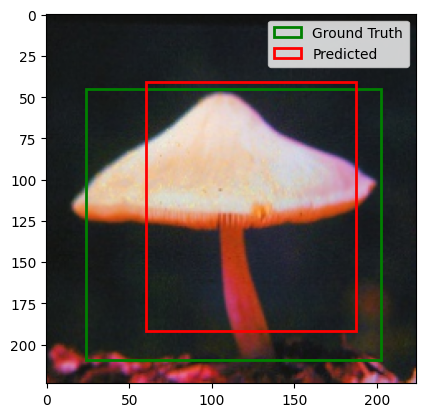

In [64]:
import matplotlib.patches as patches

def visualize_bboxes(image, gt_bbox, pred_bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot ground truth bounding box
    gt_rect = patches.Rectangle(
        (gt_bbox[0], gt_bbox[1]),
        gt_bbox[2] - gt_bbox[0],
        gt_bbox[3] - gt_bbox[1],
        linewidth=2,
        edgecolor='g',
        facecolor='none',
        label='Ground Truth'
    )
    ax.add_patch(gt_rect)

    # Plot predicted bounding box
    pred_rect = patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),
        pred_bbox[2] - pred_bbox[0],
        pred_bbox[3] - pred_bbox[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none',
        label='Predicted'
    )
    ax.add_patch(pred_rect)

    plt.legend()
    plt.show()

# Load the trained model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Choose the index of the image you want to visualize from the validation set
selected_index = 5  # Change this to the index you want to visualize

# Get the sample from the validation set
sample_image, sample_gt_bbox, sample_label = validset[selected_index]

# Move data to device
sample_image = sample_image.unsqueeze(0).to(DEVICE)

# Make a prediction
with torch.no_grad():
    pred_bboxes, _ = model(sample_image)

# Convert tensor to numpy arrays
sample_image_np = sample_image.squeeze().permute(1, 2, 0).cpu().numpy()
sample_gt_bbox_np = sample_gt_bbox.numpy()
sample_pred_bbox_np = pred_bboxes.squeeze().cpu().numpy()

# Visualize the image and bounding boxes
visualize_bboxes(sample_image_np, sample_gt_bbox_np, sample_pred_bbox_np)
